In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cortico_cereb_connectivity.run_model as rm

In [20]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
logalpha_list = [8, 8, 8, 8, 8, 10, 6]

df_all = pd.DataFrame()
for ds, la in zip(dataset_list, logalpha_list):
    df_1 = rm.comb_eval(models=[f'{ds}-avg-Cavg'], eval_data=['HCPur100task'], methods=['L2reg'], cerebellum='MNISymC3')
    df_1 = df_1[df_1['logalpha'] == la].reset_index()
    df_1["dataset_type"] = 'avg'
    df_2 = rm.comb_eval(models=[f'{ds}-group-Cavg'], eval_data=['HCPur100task'], methods=['L2reg'], cerebellum='MNISymC3')
    df_2["dataset_type"] = 'group'
    df_all = pd.concat([df_all, df_1, df_2], ignore_index=True)

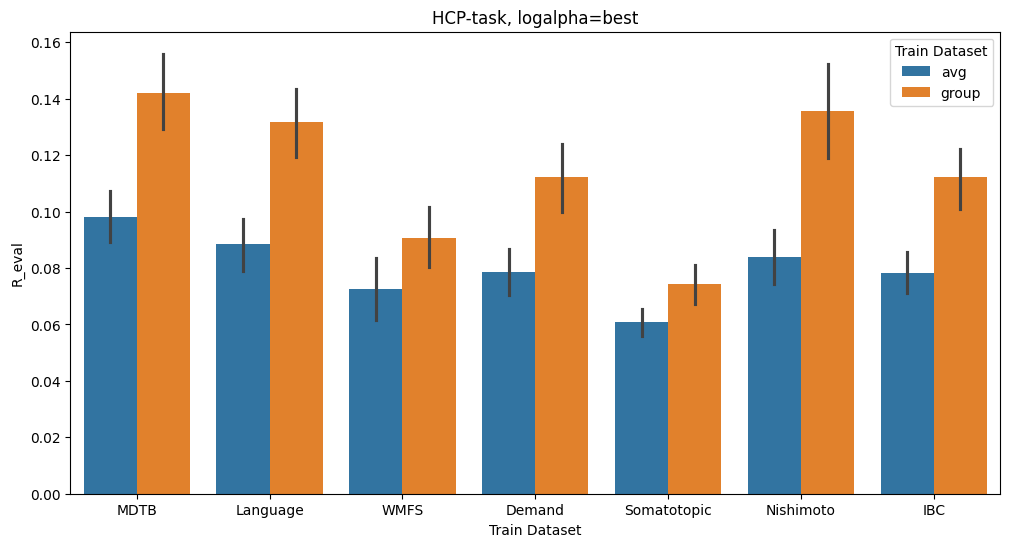

In [23]:
# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='train_dataset', y='R_eval', hue='dataset_type')
plt.title('HCP-task, logalpha=best')
plt.xlabel('Train Dataset')
plt.ylabel('R_eval')
plt.legend(title='Train Dataset')
plt.show()